#Mounting and Installation

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip3 install oiffile

     |████████████████████████████████| 133kB 4.8MB/s 
     |████████████████████████████████| 18.1MB 239kB/s 


#Image Processing

1. Open Image

In [0]:
from oiffile import imread
import numpy as np
import matplotlib.pyplot as plt
import random as rd

In [0]:
oib_file = imread('/content/gdrive/My Drive/Lab/April_Imaging/200412/TL_ER_1/200412_TL_(1)_TCO-ER_5uM_Tz26_5uM_ERRed_50nM_HeLa.oib')

In [5]:
#checking channel and frame numbers

oib_file.shape

(3, 12, 1024, 1024)

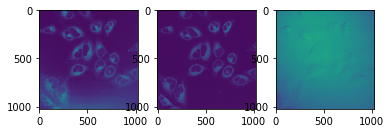

In [6]:
#making lists of each channels containing arrays of frames

ch = [[x for x in i] for i in oib_file]

#checking the image from each channel
pos = 1
x = rd.randint(0,len(ch[0])-1)
fig = plt.figure()
ax = {}
for i in range(len(ch)):
    ax[i] = fig.add_subplot(1, len(ch), pos)
    ax[i].imshow(ch[i][x])
    pos += 1
plt.show()

In [0]:
#!!! DELETION !!! of second frame from each channel. the image is bad, so I delete it
for c in ch:
    del c[1]

2. Getting Ratio Value

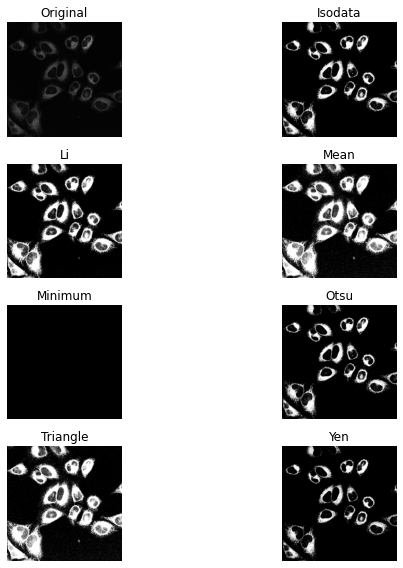

In [8]:
#checking some threshold and see which is suitable

from skimage.filters import try_all_threshold

img = ch[1][0]

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

In [0]:
#from above image I think threshold otsu is the most suitable, so I import it

from skimage.filters import threshold_otsu

In [0]:
#getting ratio value

ratio = [np.divide(ch[0][i], ch[1][i]) for i in range(len(ch[0]))]

def get_mask(image):
#A function to generate the binary mask by thresholding
    th = threshold_otsu(image)
    binary_mask = np.where(image > th, 1, 0) #the binary mask is 0s and 1s, without 'np.where' function it will be boolean (True and False), the result would still be the same
    return binary_mask

#getting binary images
masks = [get_mask(image) for image in ch[1]]

#getting masked ratio
masked_ratio = np.multiply(ratio, masks)

3. Getting Cell Area (Segmentation)

In [0]:
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
import cv2
from skimage.segmentation import flood_fill

In [0]:
def get_filled_area(image, image_size=(1024,1024), threshold=threshold_otsu, square_size=5):
#The function to get individual cell area. My own algorithm, so might not be the most efficient, but it gets the work done
    th = threshold(image)
    im = closing(image > th, square(square_size))
    im = clear_border(im)
    labeled = label(im)
    regions = [region for region in regionprops(labeled) if region.area >= 1000]
    binary_mask = []
    for region in regions:
        premask = np.zeros(image_size)
        for r,c in region.coords:
            premask[r,c] = 1
        binary_mask.append(premask)
    
    filled_mask = []
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(15,15))
    for mask in binary_mask:
        mask = cv2.dilate(mask, kernel)
        filled = np.where((flood_fill(mask, (0,0), 1))==1, 0, 1)
        filled = np.add(filled, mask)
        filled_mask.append(filled)
    return filled_mask #the output is multichannels array, with channel number corresponds to cell number

In [0]:
#getting the cell area
areas = get_filled_area(ch[1][0])

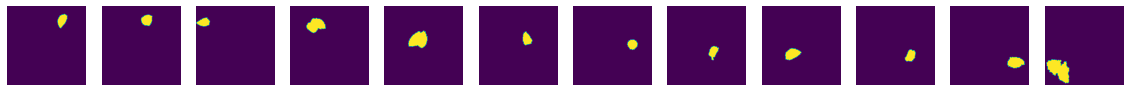

In [64]:
pos = 1
fig = plt.figure(figsize=(20,4))
ax = {}
for i in range(len(areas)):
    ax[i] = fig.add_subplot(1, len(areas), pos)
    ax[i].imshow(areas[i])
    ax[i].axis('off')
    pos += 1
plt.show()

In [0]:
#just visualization of the area as one channel array, with each cell having different pixel value thus different colors.

bin_mask = np.zeros((1024,1024))
for i in range(len(areas)):
    a = np.where(areas[i]==1, i+1, 0)
    bin_mask += a

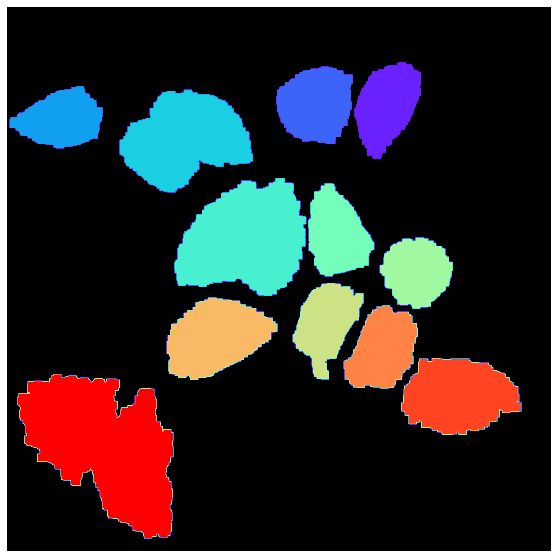

In [15]:
#visualization of the array above

fig = plt.figure(figsize=(10,10), frameon=False)
ax = fig.add_subplot()
heatmap = ax.imshow(bin_mask, cmap='rainbow', vmin=0.5)
heatmap.cmap.set_under('black')
plt.axis('off')
plt.show()

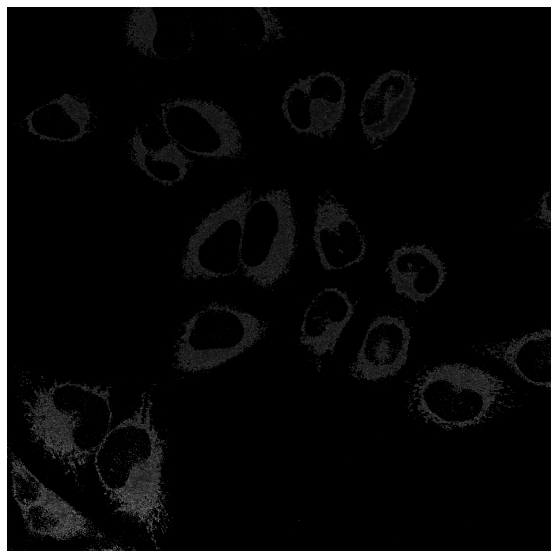

In [16]:
fig = plt.figure(figsize=(10,10), frameon=False)
ax = fig.add_subplot()
heatmap = ax.imshow(masked_ratio[0], cmap='gray', vmin=0.1)
heatmap.cmap.set_under('black')
plt.axis('off')
plt.show()

4. Get Mean Ratio from Each Cell

In [0]:
def get_cell_value(image, cell_area):
#A function to generate the mean value from individual cell area
    mean_val = []
    for cell in cell_area:
        cell_val = np.multiply(cell, image)
        mean_val.append(cell_val[np.nonzero(cell_val)].mean())
    return mean_val

#getting mean ratio value from each cell
total_mean = [get_cell_value(image, areas) for image in masked_ratio]

In [0]:
ch1_masked = np.multiply(masks, ch[0])
ch2_masked = np.multiply(masks, ch[1])
ch1_val = [get_cell_value(image, areas) for image in ch1_masked]
ch2_val = [get_cell_value(image, areas) for image in ch2_masked]

5. Plotting

In [0]:
import pandas as pd

data = pd.DataFrame(total_mean)
data1 = pd.DataFrame(ch1_val)
data2 = pd.DataFrame(ch2_val)

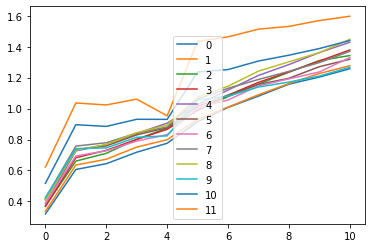

In [21]:
data.plot()

In [22]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.319150,0.336105,0.369103,0.367682,0.383003,0.411649,0.388213,0.420930,0.408813,0.424903,0.516783,0.622229
1,0.606388,0.635063,0.660419,0.682281,0.726565,0.734712,0.693638,0.757444,0.731721,0.741373,0.895748,1.036195
2,0.643582,0.672460,0.710797,0.730091,0.766445,0.758572,0.727190,0.779306,0.767820,0.745665,0.884724,1.023312
3,0.717925,0.750945,0.801423,0.800470,0.838610,0.829835,0.789865,0.841216,0.844231,0.814380,0.930670,1.061083
4,0.775778,0.798730,0.873501,0.866116,0.906144,0.876944,0.831349,0.881049,0.893187,0.823765,0.930218,0.953090


In [23]:
len(data)

11

In [0]:
#getting mean ratio value from all cell values
mean_ratio = [np.mean(data.loc[i,:]) for i in range(len(data))]

In [0]:
#for x axis, which represents time. from 0 to 60 minutes with 5 minutes interval
x = list(np.arange(0,56,5))
#because the second frame was deleted
del x[1]

In [0]:
mean_ch1 = [np.mean(data1.loc[i,:]) for i in range(len(data1))]
mean_ch2 = [np.mean(data2.loc[i,:]) for i in range(len(data2))]

In [0]:
err = [np.std(data.loc[i,:]) for i in range(len(data))]
err1 = [np.std(data1.loc[i,:]) for i in range(len(data1))]
err2 = [np.std(data2.loc[i,:]) for i in range(len(data2))]

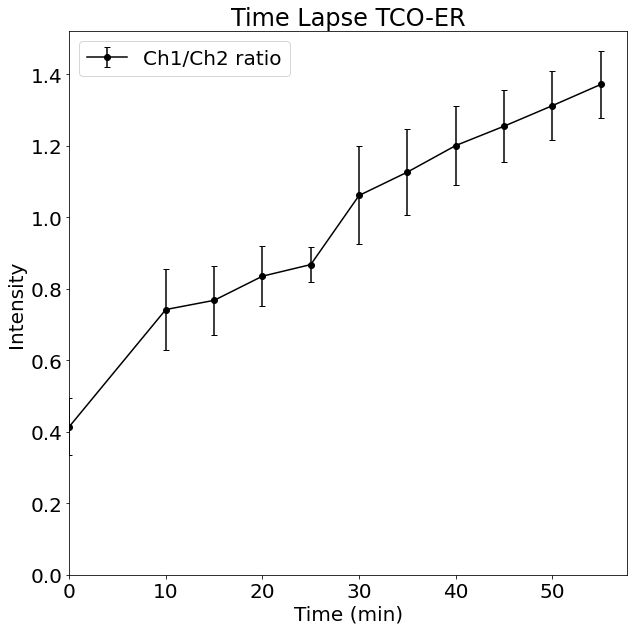

In [28]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size':20})
plt.errorbar(x, mean_ratio, yerr=err, fmt='o', xlolims=0, ecolor='black', ls='-', c='black', capsize=3, label='Ch1/Ch2 ratio')
plt.title('Time Lapse TCO-ER')
plt.xlim(0)
plt.ylim(0)
plt.legend()
plt.xlabel('Time (min)')
plt.ylabel('Intensity')
plt.savefig('TLER.png')

#Visualization (making ratiometric video)

In [0]:
import io

def get_img_from_fig(fig, dpi=180):
#A function to turn plot into image (np array), I got it from internet.
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=dpi, bbox_inches='tight', pad_inches=0, transparent=True, frame_on=False)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

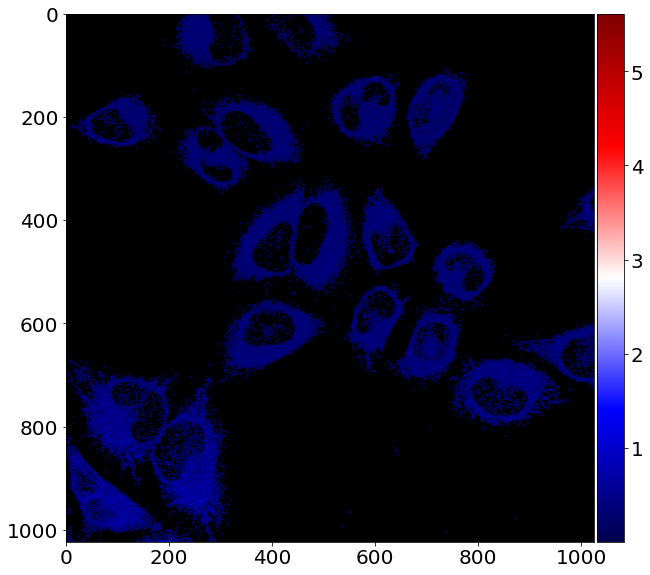

In [52]:
fig = plt.figure(figsize=(10,10), frameon=False)
ax = fig.add_subplot()
heatmap = ax.imshow(masked_ratio[0], cmap=plt.cm.seismic, 
                    vmin=0.0000001, vmax=np.max(masked_ratio))
heatmap.cmap.set_bad(color='black')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(heatmap, cax=cax)
plt.show()

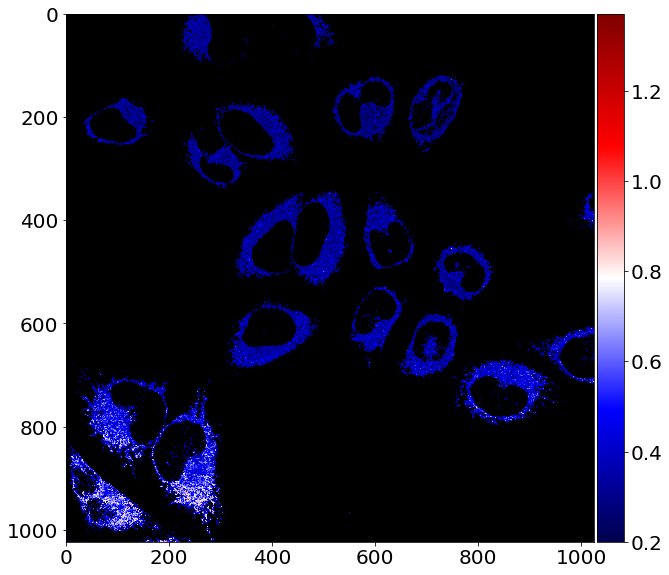

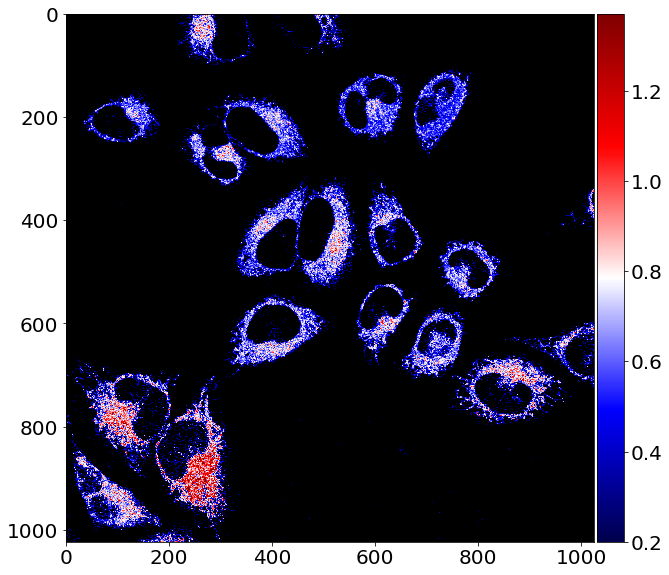

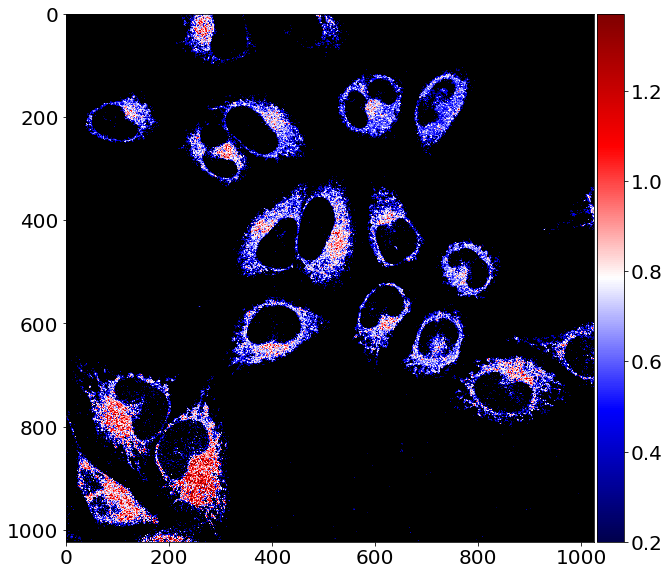

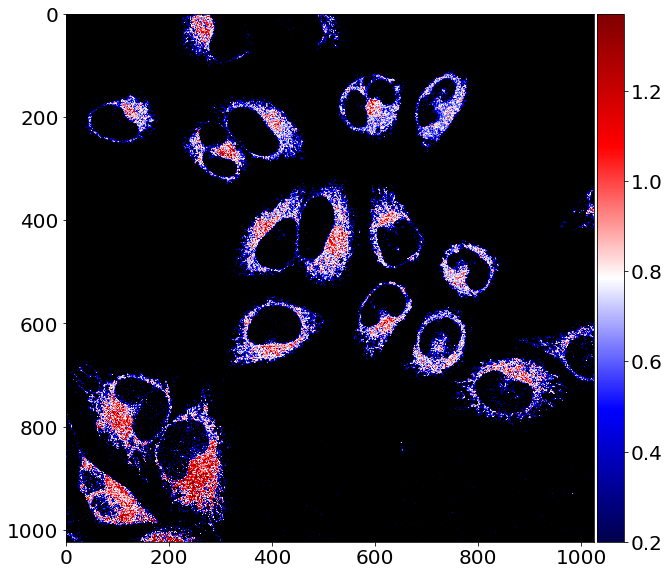

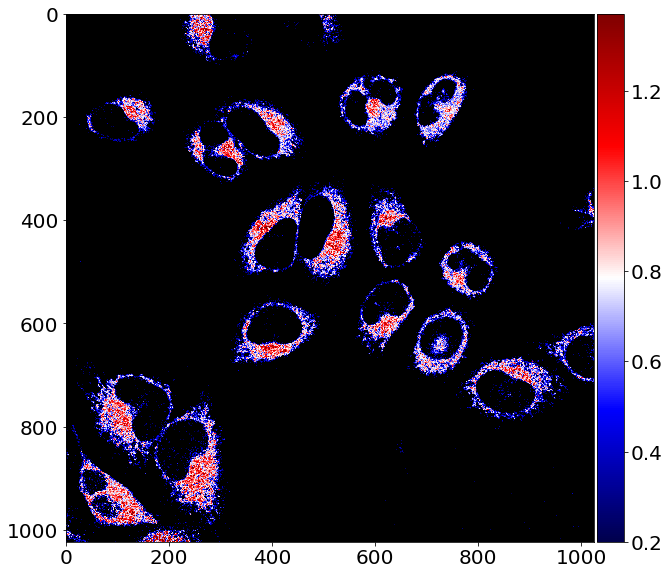

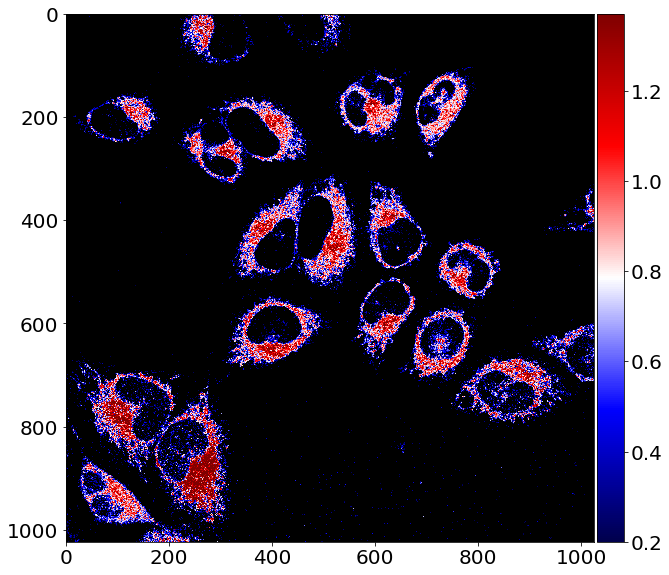

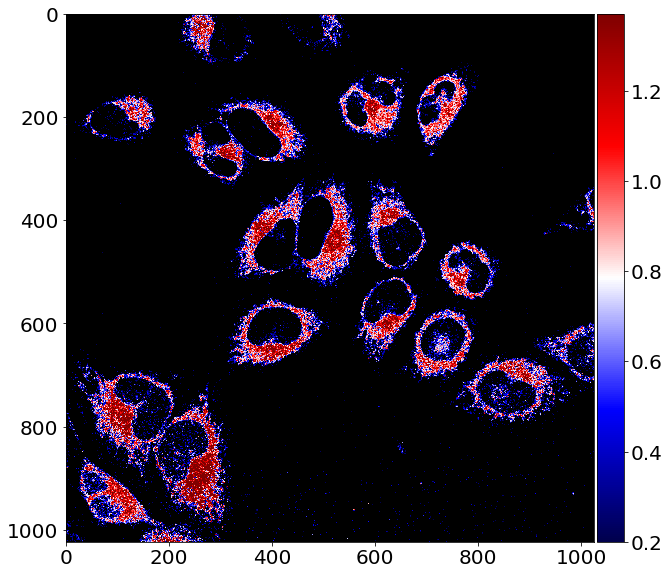

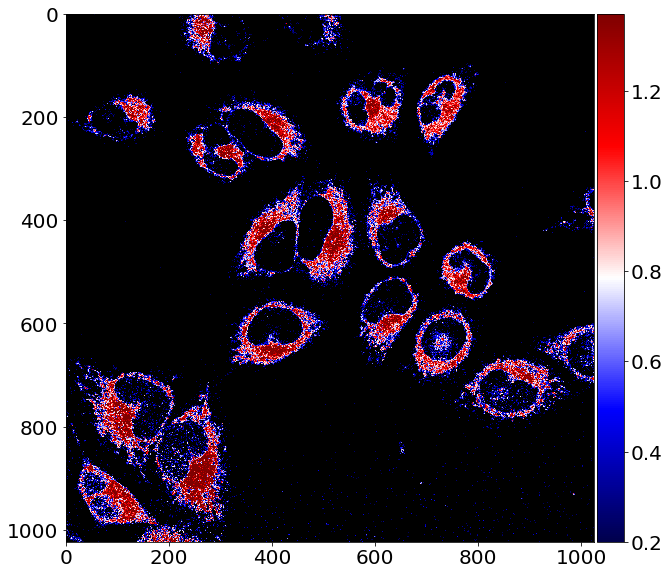

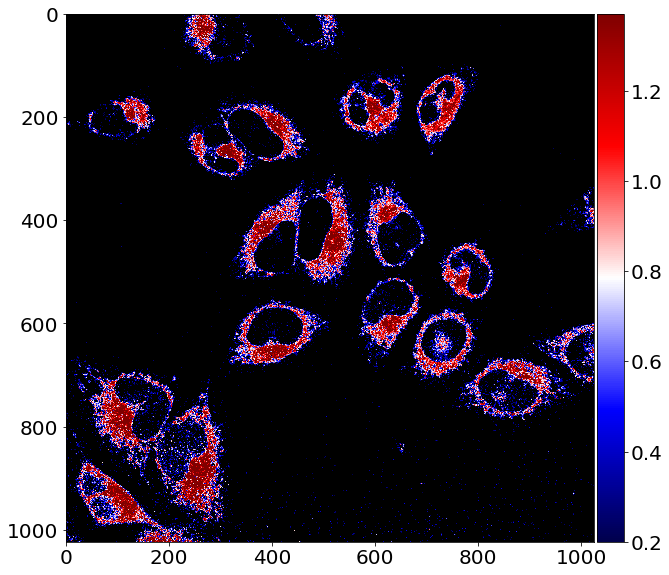

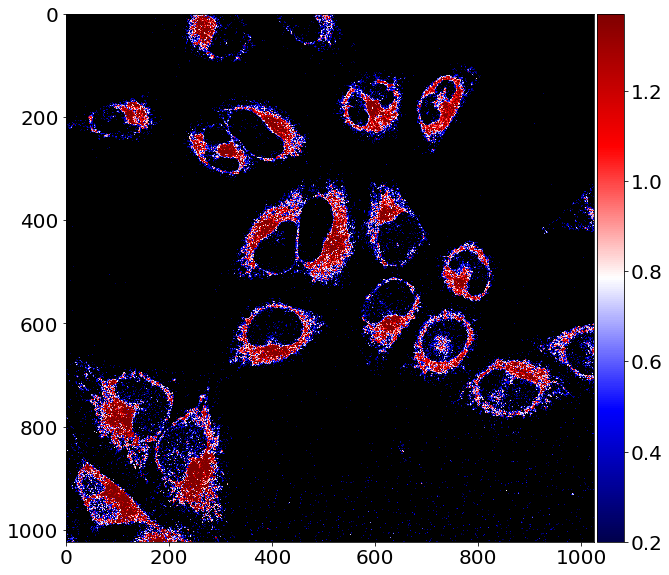

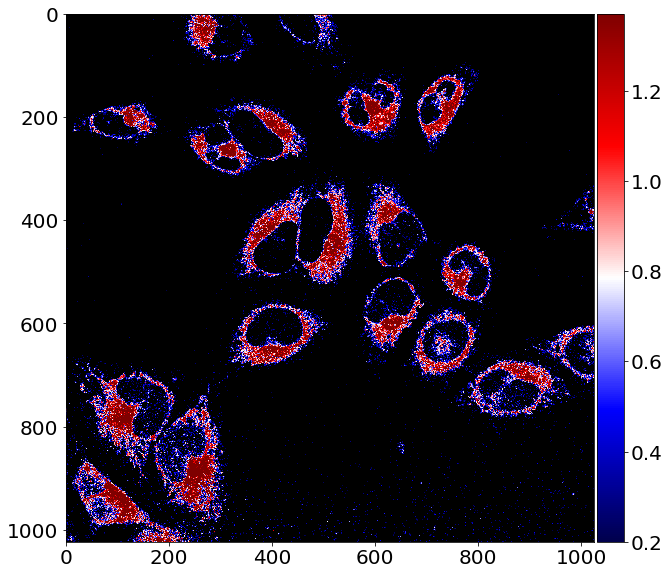

In [53]:
imlist = []

for i in range(len(masked_ratio)):
    fig = plt.figure(figsize=(10,10), frameon=False)
    ax = fig.add_subplot()
    heatmap = ax.imshow(masked_ratio[i], cmap=plt.cm.seismic, 
                        vmin=0.2, vmax=1.37)
    heatmap.cmap.set_under('black')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(heatmap, cax=cax)
    img_fig = get_img_from_fig(fig)
    imlist.append(img_fig)

In [0]:
video_name = 'TL_ER_fps2.avi'

height, width, layers = imlist[0].shape

video = cv2.VideoWriter(video_name, 0, 2, (width,height))

for im in imlist:
    video.write(im)

cv2.destroyAllWindows()
video.release()